Importing libraries

In [1]:
import pandas as pd
from google.colab import files

Importing training and testing set

In [ ]:
!git clone 'https://github.com/hoankm94/WaterPH.git'

In [ ]:
url = '/content/WaterPH/Work/ML_training/Data/Dec31.csv'
df = pd.read_csv(url, names = ['410nm', '435nm', '460nm', '485nm', '510nm', '535nm', '560nm',
                               '585nm', '610nm', '645nm', '680nm', '705nm', '730nm', '760nm',
                               '810nm', '860nm', '900nm', '940nm', 'pH', 'Date'])
# Remove rows with dates
df = df.dropna(subset=[df.columns[17]])

# Remove characters
for column in df.columns:
    if df[column].dtype == object:
        df[column] = df[column].str.replace('[', '', regex=False).str.replace(']', '', regex=False)

# Change cols' data type back after character remove
df['410nm'] = pd.to_numeric(df['410nm'], downcast=None)
df['940nm'] = pd.to_numeric(df['940nm'], downcast=None)
df['pH'] = pd.to_numeric(df['pH'], downcast=None)

df = df.drop(['Date'], axis = 1)
df.info()

Sort dataframe

In [4]:
df.sort_values(by=['pH'], inplace=True, ascending=True)
df.to_csv('Dec31_processed.csv', index = False)
# df.pH.head(10)

Cleaning the data

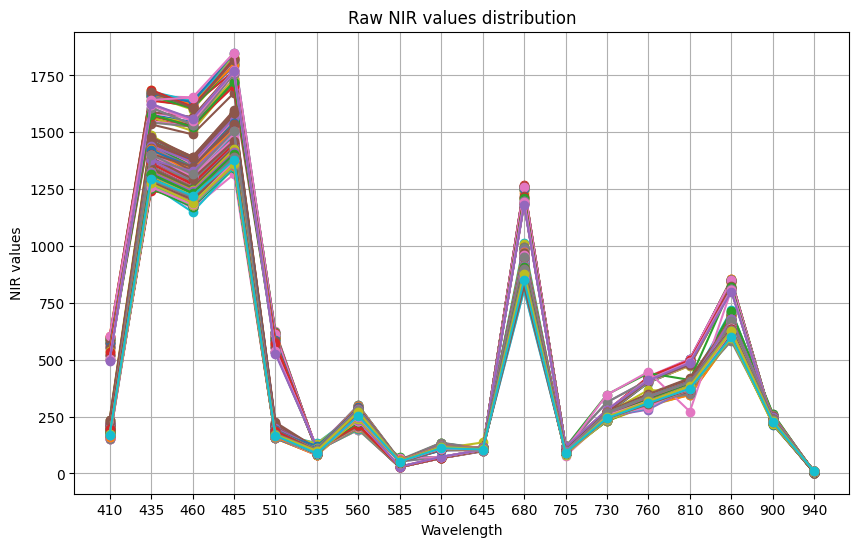

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Extract relevant data for plotting
x = df.columns[df.columns != 'pH'].str.replace('nm', '')  # Remove 'nm' from wavelength labels
y_cols = df[df.columns[1:]].T  # Transpose to have wavelengths as rows

# Plot each observation as a line with pH value as label
plt.figure(figsize=(10, 6))
for i, col in enumerate(y_cols.columns):
    plt.plot(x, y_cols[col], marker='o', label=f'pH {df.iloc[i, 0]}')  # Use pH value for label
plt.xlabel('Wavelength')  # Removed 'nm' from x-axis label
plt.ylabel('NIR values')
plt.title('Raw NIR values distribution')  # Removed 'nm' from title
plt.grid(True)
# plt.legend()
plt.show()

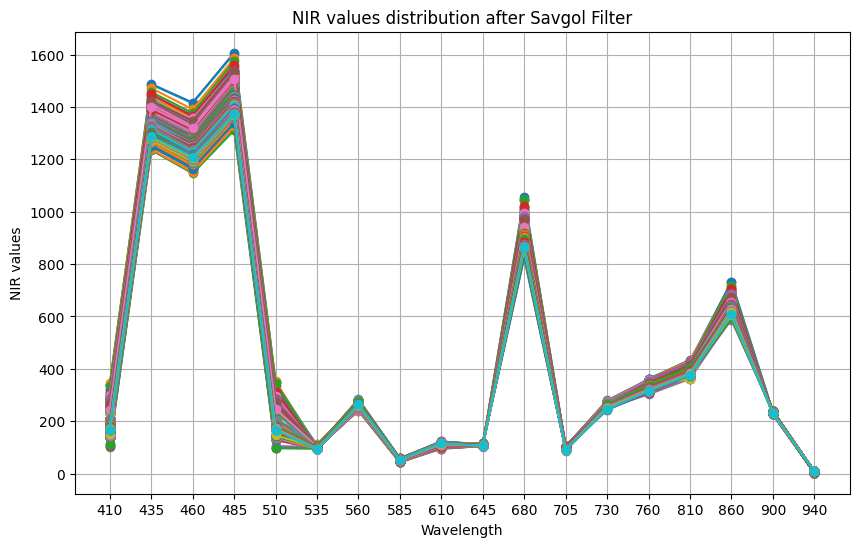

In [6]:
# @title Savgol_filter for smoothing data
from scipy.signal import savgol_filter

# Define parameters
window_length = 9  # Must be an odd integer
polyorder = 2      # Polynomial order

# Apply Savgol filter to spectral data columns (all except the pH column)
smoothed_data = df.iloc[:, :-1].apply(
    lambda x: savgol_filter(x, window_length=window_length, polyorder=polyorder), axis=0
)

# Combine smoothed data with the pH column
smoothed_data['pH'] = df['pH']

# Extract relevant data for plotting
x = smoothed_data.columns[smoothed_data.columns != 'pH'].str.replace('nm', '')  # Remove 'nm' from wavelength labels
y_cols = smoothed_data[smoothed_data.columns[1:]].T  # Transpose to have wavelengths as rows

# Plot each observation as a line with pH value as label
plt.figure(figsize=(10, 6))
for i, col in enumerate(y_cols.columns):
    plt.plot(x, y_cols[col], marker='o', label=f'pH {df.iloc[i, 0]}')  # Use pH value for label
plt.xlabel('Wavelength')  # Removed 'nm' from x-axis label
plt.ylabel('NIR values')
plt.title('NIR values distribution after Savgol Filter')  # Removed 'nm' from title
plt.grid(True)
# plt.legend()
plt.show()

In [ ]:
# @title (test space) Sagov_filter fine-tuning visualization

# Select a subset of the data for fine-tuning visualization
subset_index = 0  # Selecting the first row as an example
original_values = df.iloc[subset_index, :-1]  # Exclude the pH column
wavelengths = df.columns[:-1]

# Define parameter combinations for fine-tuning
window_lengths = [7, 9]  # Test smaller and larger windows
polyorders = [2]          # Test quadratic and cubic polynomials

# Plot the original data
plt.figure(figsize=(12, 8))
plt.plot(wavelengths, original_values, label='Original', linewidth=2, linestyle='--', color='black')

# Apply and plot smoothing for each combination of parameters
for wl in window_lengths:
    for po in polyorders:
        # Ensure window_length is valid for polyorder
        if wl > po:
            smoothed_values = savgol_filter(original_values, window_length=wl, polyorder=po)
            plt.plot(wavelengths, smoothed_values, label=f'window_length={wl}, polyorder={po}')

# Finalize plot
plt.title('Effect of Savitzky-Golay Filter Parameters on Smoothing')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()


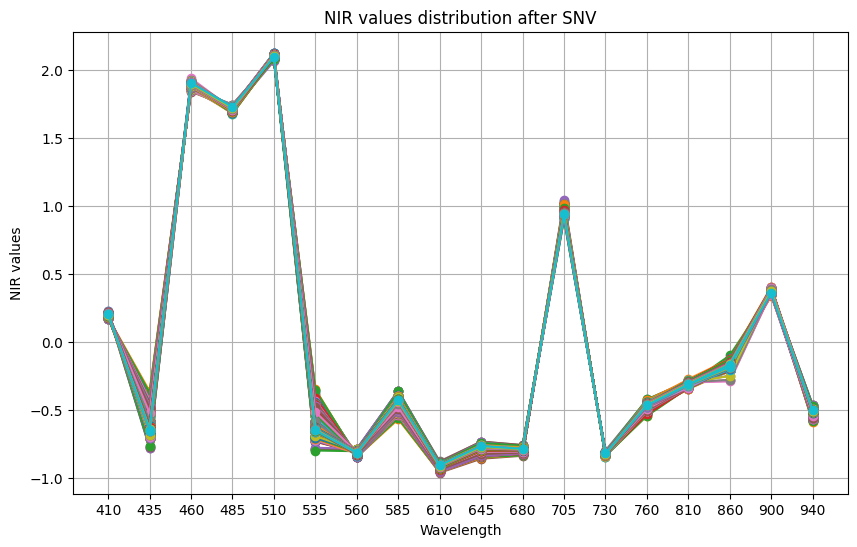

In [8]:
# @title SNV Preprocessing
def snv(data):
    # Center each spectrum by subtracting its mean
    data_centered = data - data.mean(axis=1).values.reshape(-1, 1)
    # Scale each spectrum by dividing by its standard deviation
    data_snv = data_centered / data_centered.std(axis=1).values.reshape(-1, 1)
    return data_snv

spectral_data = smoothed_data.drop(columns=['pH'])
snv_data = snv(spectral_data)

# Convert the NumPy array back to a DataFrame
snv_df = pd.DataFrame(snv_data, columns=spectral_data.columns)

# Add the 'pH' column back to the DataFrame
snv_df['pH'] = smoothed_data['pH']

# --- Plot SNV Data ---
x = snv_df.columns[snv_df.columns != 'pH'].str.replace('nm', '')
y = snv_df.drop(columns=['pH']).values  # Exclude 'pH' for plotting

plt.figure(figsize=(10, 6))
for i in range(y.shape[0]):
    plt.plot(x, y[i, :], marker='o')
plt.xlabel('Wavelength')
plt.ylabel('NIR values')
plt.title('NIR values distribution after SNV')
plt.grid(True)
plt.show()

In [10]:
# @title Standard Scaler
x = snv_df.drop('pH', axis = 1)
y = snv_df['pH']

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(x)
scaled_df = pd.DataFrame(scaled_data, columns= x.columns)

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.2, random_state = 42)

In [ ]:
# @title Feature selection
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression

# SelectKBest
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(x_train, y_train)

# Get feature scores and names
scores = selector.scores_
feature_names = x.columns

# Create DataFrame for plotting
df_scores = pd.DataFrame({'Feature': feature_names, 'Score': scores})
# df_scores = df_scores.sort_values(by=['Score'], ascending=False)  # Optional sorting

# Set the global font size
plt.rcParams.update({'font.size': 18})

# Create the bar plot with a larger figure size
plt.figure(figsize=(14, 10))
plt.bar(df_scores['Feature'], df_scores['Score'])

# Customize individual text elements with very large font sizes
plt.xlabel('Feature', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.title('Feature Importance Scores from SelectKBest', fontsize=24)

plt.xticks(rotation=90, fontsize=18)
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('feature_importance_larger.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# @title Trying all models
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LassoCV, LassoLarsCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error


models = {
    "Lasso": Lasso(random_state=42),
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LassoCV": LassoCV(),
    "LassoLarsCV": LassoLarsCV(),
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "SVR": SVR(kernel='linear'),
    "GaussianProcessRegressor": GaussianProcessRegressor(kernel=RBF(), random_state=42)
    # "BayesianLinearRegression": BayesianLinearRegression(),
    # "PolynomialRegression": PolynomialRegression(degree=3),
    # "StepwiseLinearRegression": StepwiseLinearRegression(forward = True, backward=True, verbose=2),
}

results = []

for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)  # Predict on the test set
    r2 = model.score(x_test, y_test)  # R-squared
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    results.append([model_name, r2, rmse])  # Store both metrics

results_df = pd.DataFrame(results, columns=["Model", "R-squared Score", "RMSE"])
print(results_df)

In [ ]:
# @title GPR with Spectral Mixture kernel
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Convert data to PyTorch tensors
train_x = torch.tensor(x_train, dtype=torch.float32)
test_x = torch.tensor(x_test, dtype=torch.float32)
train_y = torch.tensor(y_train.values, dtype=torch.float32).flatten()
test_y = torch.tensor(y_test.values, dtype=torch.float32).flatten()

# Define the GP model with the Spectral Mixture kernel
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=train_x.shape[1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model (using the Spectral Mixture kernel)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

# Train the model (optimize hyperparameters)
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Loss function - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 300  # Increase if needed
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

# Get into evaluation mode
model.eval()
likelihood.eval()

# Make predictions on training and test data
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_predictions = likelihood(model(train_x))
    test_predictions = likelihood(model(test_x))

# Calculate R^2 and RMSE
train_r2 = r2_score(train_y.numpy(), train_predictions.mean.numpy())
train_rmse = np.sqrt(mean_squared_error(train_y.numpy(), train_predictions.mean.numpy()))
test_r2 = r2_score(test_y.numpy(), test_predictions.mean.numpy())
test_rmse = np.sqrt(mean_squared_error(test_y.numpy(), test_predictions.mean.numpy()))

print(f"Train R^2: {train_r2:.4f}, Train RMSE: {train_rmse:.4f}")
print(f"Test R^2: {test_r2:.4f}, Test RMSE: {test_rmse:.4f}")

In [ ]:
# @title (testing) Apply models again using selected features using SelectKBest
# Range of k values to try
k_values = range(1, 19)  # k values from 1 to 18

# Store results for each k value
results = []

# Loop through k values
for k in k_values:
    # Apply SelectKBest with the current k value
    selector = SelectKBest(score_func=f_regression, k=k)
    x_train_selected = selector.fit_transform(x_train, y_train)
    x_test_selected = selector.transform(x_test)

    # Apply Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(x_train_selected, y_train)

    # Evaluate the model (e.g., using R-squared)
    score = rf.score(x_test_selected, y_test)

    # Store the results
    results.append([k, score, selector])  # Store selector object

# Find the best result
best_result = max(results, key=lambda item: item[1])  # Find max based on R-squared score

# Extract information from the best result
best_k = best_result[0]
best_score = best_result[1]
best_selector = best_result[2]
best_selected_features = x.columns[best_selector.get_support()]

# Print the information related to the best result
print(f"Best number of features: {best_k}")
print(f"Highest R-squared Score: {best_score}")
print(f"Selected Features: {best_selected_features if best_result[0] < 18 else 'All'}")

# Retrain the model with the best features
selector = SelectKBest(score_func=f_regression, k=best_k)
x_train_selected = selector.fit_transform(x_train, y_train)
x_test_selected = selector.transform(x_test)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train_selected, y_train)

# Make predictions on the test set
y_pred = rf.predict(x_test_selected)

# Create the Predicted vs Actual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)  # Scatter plot of actual vs predicted
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=2)  # Diagonal line
plt.xlabel('Actual pH')
plt.ylabel('Predicted pH')
plt.title('Predicted vs Actual pH')
plt.grid(True)
plt.show()

In [ ]:
# @title Param Tuning for RF
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np

# # Define the hyperparameter grid for Grid Search
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Explore around the previous best (100)
#     'max_features': [0.4, 0.5, 0.6, 'sqrt', 'log2'], # Explore around 0.5 and sqrt/log2
#     'max_depth': [8, 10, 12, 15],  # Explore around the previous best (10)
#     'min_samples_split': [2, 3, 4],  # Focus on smaller values
#     'min_samples_leaf': [1, 2],  # Focus on smaller values
#     'bootstrap': [True],
#     'criterion': ['squared_error']
# }

# rf = RandomForestRegressor(random_state=42)

# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# grid_search.fit(x_train, y_train)

# # Get the best parameters and best estimator
# best_params = grid_search.best_params_
# best_rf = grid_search.best_estimator_

# # Evaluate the best model on the test set
# y_pred = best_rf.predict(x_test)

# # Calculate RMSE and R-squared
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)

# print(f"Best Parameters: {best_params}")
# print(f"RMSE: {rmse}")
# print(f"R-squared: {r2}")